## Basic Setup

In [43]:
import sys, pathlib

sys.path.append("..")

from scripts.data_loaders.common import show_sample

# importing datasets from dataloader
from scripts.data_loaders.L2ARCTIC import (
    L2ArcticDataset,
    all_arctic_speaker_splits,
    SPEAKERS,
)
from scripts.data_loaders.TIMIT import TIMITDataset
from scripts.data_loaders.PSST import PSSTDataset
from scripts.data_loaders.OSUBuckeye import BuckeyeDataset, all_buckeye_speaker_splits
from scripts.data_loaders.DoReCo import DoReCoDataset
from scripts.data_loaders.EpaDB import EpaDBDataset
from scripts.data_loaders.SpeechOcean import SpeechOceanDataset
from scripts.data_loaders.common import split_utterance_into_multiple

from scripts.forced_alignment.common import sequence_to_vectors


from scripts.eval.evaluate import evaluate
from scripts.eval.metrics import per, fer
from scripts.ipa_transcription.wav2vec2 import transcribe_batch

from scripts.core.ipa import filter_chars, simplify_ipa, canonize, remove_stress_marker
from scripts.core.audio import TARGET_SAMPLE_RATE
from IPython.display import clear_output

clear_output()

# imports for finetuning


import logging
import torch
import wandb
import json
import numpy as np
import pandas as pd
import torchaudio
import os
import matplotlib.pyplot as plt

from transformers import (
    Trainer,
    TrainingArguments,
    Wav2Vec2Processor,
    Wav2Vec2FeatureExtractor,
    set_seed,
)
from datasets import Dataset
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import functools
from sklearn.model_selection import train_test_split
from sklearn import logger

In [42]:
PRE_TRAINED_ID = "facebook/wav2vec2-xlsr-53-phon-cv-ft"

In [4]:
processor = Wav2Vec2Processor.from_pretrained(PRE_TRAINED_ID)
tokenizor = processor.tokenizer
model_vocab = tokenizor.get_vocab()

In [5]:
PROJECT_NAME = "Facebook_Finetune_A"

In [6]:
BATCH_SIZE_MAP = 32
NUM_PROC_MAP = 4  # adjust
RNG_SEED = 42  # rando seed, KEEP CONST

In [81]:
MATCHED_VOCAB = {
    "a",
    "ʒ",
    "ɨ",
    "ɡ",
    "d",
    "ɦ",
    "ɛ",
    "ɾ",
    "o",
    "θ",
    "æ",
    "ŋ",
    "u",
    "ɝ",
    "p",
    "ɒ",
    "ə",
    "ɔ",
    "ʔ",
    "t",
    "v",
    "x",
    "ɹ",
    "β",
    "i",
    "s",
    "f",
    "m",
    "z",
    "ʌ",
    "ʊ",
    "l",
    "n",
    "h",
    "ɪ",
    "ɚ",
    "ɑ",
    "e",
    "w",
    "k",
    "ʉ",
    "b",
    "ɜ",
    "ð",
    "j",
    "ʃ",
    "r",
    "aʊ",
    "dʒ",
    "dz",
    "l̩",
    "pʰ",
    "ɛ̃",
    "m̩",
    "æ̃",
    "aɪ",
    "eɪ",
    "ɑ̃",
    "ɔɪ",
    "kʰ",
    "ts",
    "n̩",
    "tʃ",
    "ʊ̃",
}

# Load Data

### Dataset viewing: 
look at dataset statistics, you can skip this.  

#### EpaDB dataset
**About**: 
1894 samples 0.02-0.17 in length, 98 minutes total (no audio clipping) 
some special characters that will be mapped. 

Simplified vocab: {'ɛ', 'ŋ', 'b', 'd', 'ʍ', 'ɪ', 'f', 'ɾ̃', 'r', 'ə', 'l', 'ɑ', 'θʰ', 'k', 'v', 'pʰ', 'aɪ', 'oʊ', 'a', 'æ', 'n̩', 'h', 'x', 'ɾ', 'ɔ', 'ɡ', 'w', 'ʌ', 'ʉ', 'z', 'ɝ', 'eɪ', 'u', 'ʔ', 'ɨ', 'ɔɪ', 'kʰ', 'n', 'aʊ', 'e', 'ɹ', 'm', 'ʟ', 'dʒ', 'ʒ', 'm̩', 't', 'p', 'ɚ', 'β', 'o', 'sʰ', 'ʊ', 's', 'i', 'j', 'l̩', 'ð', 'ɡɣ', 'tʃ'}

not found: ['ɡɣ', 'ɝ', 'ɾ̃', 'ʍ', 'θʰ', 'm̩', 'sʰ', 'ʟ']


In [32]:
epadb = EpaDBDataset(split="train")

#### PSST dataset
**About**: 2298 samples, 0.1 to 1.2 minutes, 166 minutes total (no audio clipping)
some small sample annotation ambiguities to be discussed later

Simplified Vocab: {'ɛ', 'ŋ', 'b', 'd', 'ʍ', 'ɪ', 'f', 'ɾ̃', 'ə', 'l', 'ɑ', 'k', 'v', 'aɪ', 'oʊ', 'æ', 'n̩', 'h', 'θ', 'ɾ', 'ɔ', 'ɡ', 'w', 'ʌ', 'ʉ', 'z', 'ɝ', 'eɪ', 'u', 'ʔ', 'ɨ', 'ɔɪ', 'n', 'aʊ', 'ɹ', 'm', 'dʒ', 'ʒ', 'm̩', 't', 'p', 'ɚ', 'ʊ', 's', 'i', 'j', 'l̩', 'ð', 'tʃ', 'ʃ'}

not found: ['ɝ', 'ɾ̃', 'ʍ', 'm̩']

In [33]:
psst = PSSTDataset(split="train", force_offline=True)

psstdata INFO: Loaded data version local at /Users/arunasrivastava/Koel/ML-eval/ML/notebooks/../scripts/data_loaders/../../.data/psst-data


#### Timit dataset
**About**: 4620 samples, 0.013 to 0.12 minutes, 222 minutes total (no audio clipping)

Simplified vocab: {'ɛ', 'ŋ', 'b', 'd', 'ʍ', 'ɪ', 'f', 'ɾ̃', 'ə', 'l', 'ɑ', 'k', 'v', 'aɪ', 'oʊ', 'æ', 'n̩', 'h', 'θ', 'ɾ', 'ɔ', 'ɡ', 'w', 'ʌ', 'ʉ', 'z', 'ɝ', 'eɪ', 'u', 'ʔ', 'ɨ', 'ɔɪ', 'n', 'aʊ', 'ɹ', 'm', 'ɦ', 'dʒ', 'ʒ', 'm̩', 't', 'p', 'ɚ', 'ʊ', 's', 'i', 'ə̥', 'j', 'l̩', 'ð', 'ŋ̍', 'tʃ', 'ʃ'}

not found: ['ŋ̍', 'ə̥', 'ɝ', 'ɾ̃', 'ʍ', 'ɦ', 'm̩']

In [34]:
timit = TIMITDataset(split="train")

#### Suitcase L2 arctic
**About**: 22 samples, 0.459 to 3.92 minutes (26 minutes of speech)

**with audio clipping**: 153 samples, 0.16 to 0.22 minutes (23 minutes of speech)

10 seconds was found to be the best splitting length that allowed all clips to meet this threshold. 

Simplfiied vocab: {'ɛ', 'ŋ', 'b', 'd', 'ʍ', 'ɪ', 'f', 'ɾ̃', 'ə', 'l', 'ɑ', 'k', 'v', 'aɪ', 'oʊ', 'æ', 'n̩', 'h', 'θ', 'ɾ', 'ɔ', 'ɡ', 'w', 'ʌ', 'ʉ', 'z', 'ɝ', 'eɪ', 'u', 'ʔ', 'ɨ', 'ɔɪ', 'n', 'aʊ', 'ɹ', 'm', 'dʒ', 'ʒ', 'm̩', 't', 'p', 'ɚ', 'ʊ', 's', 'i', 'j', 'l̩', 'ð', 'tʃ', 'ʃ'}

not found: ['ɝ', 'ɾ̃', 'ʍ', 'm̩']

In [35]:
suitcase = L2ArcticDataset(
    split="suitcase_corpus", include_timestamps=True
)  # spontaneous speech

audio cropping... 

first check audio length

Total audio length in minutes: 26.100249999999996
number of samples: 22


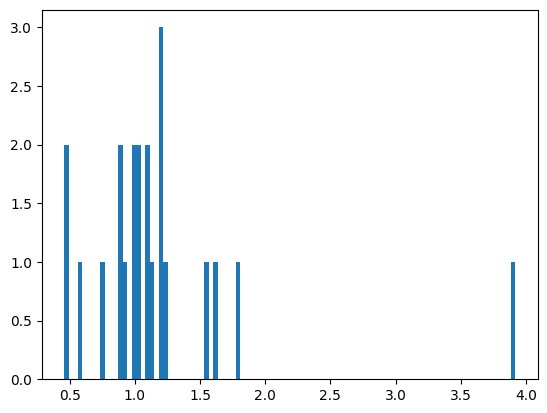

In [36]:
audio_lens = []
for sample in suitcase:
    audio_lens.append(len(sample[1]) / 16000 / 60)
plt.hist(audio_lens, bins=100)
original_total_audio = sum(audio_lens)
print("Total audio length in minutes:", original_total_audio)
print("number of samples:", len(suitcase))

total audio length in minutes: 23.145196875
number of samples: 129
min length: 0.16676666666666667
max length: 0.2055


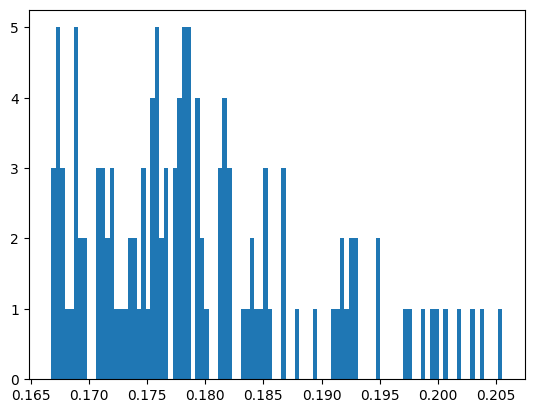

In [37]:
new_audio_lens = []
# new ipa and audio
refined_suitcase = []

for sample in suitcase:
    subsamples = split_utterance_into_multiple(sample[2], sample[1], 0.01, 10)
    for subsample in subsamples:
        new_audio_lens.append(len(subsample[1]) / 16000 / 60)
        refined_suitcase.append((remove_stress_marker(subsample[0]), subsample[1]))

#  plot audio lens
plt.hist(np.array(new_audio_lens), bins=100)
new_total_audio = sum(np.array(new_audio_lens))
print("total audio length in minutes:", new_total_audio)
print("number of samples:", len(refined_suitcase))
print("min length:", min(new_audio_lens))
print("max length:", max(new_audio_lens))

#### Buckeye dataset
**About**: 255 samples, 4-10 minutes (1704 minutes)
**with audio clipping**: 3026 samples, 30 seconds, 0.1 (1587 minutes)

Simplified vocab: {'ɛ', 'ŋ', 'd', 'b', 'ɪ', 'f', 'ɾ̃', 'l', 'ɑ', 'k', 'æ̃', 'ɛ̃', 'v', 'aɪ', 'oʊ', 'æ', 'n̩', 'oʊ̃', 'θ', 'h', 'ɾ', 'ɔ', 'ɡ', 'w', 'aɪ̃', 'ʌ', 'ɑ̃', 'z', 'eɪ', 'u', 'ʔ', 'ə̃', 'ɔɪ', 'n', 'aʊ', 'ɹ', 'm', 'dʒ', 'ĩ', 'ʒ', 'm̩', 't', 'ʊ̃', 'p', 'ɚ', 'ʊ', 's', 'i', 'j', 'l̩', 'ð', 'ŋ̍', 'tʃ', 'ʃ'}

Not found: ['ŋ̍', 'oʊ̃', 'ɾ̃', 'æ̃', 'ʊ̃', 'm̩', 'ə̃', 'aɪ̃']

In [38]:
buckeye = all_buckeye_speaker_splits(include_timestamps=True)  # scripted speech

check audio length

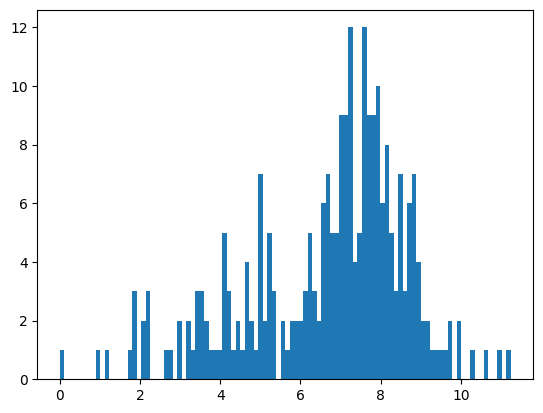

In [39]:
audio_lens = []
for sample in buckeye:
    audio_lens.append(len(sample[1]) / 16000 / 60)
plt.hist(audio_lens, bins=100);

total audio length in minutes: 1587.0021604166643


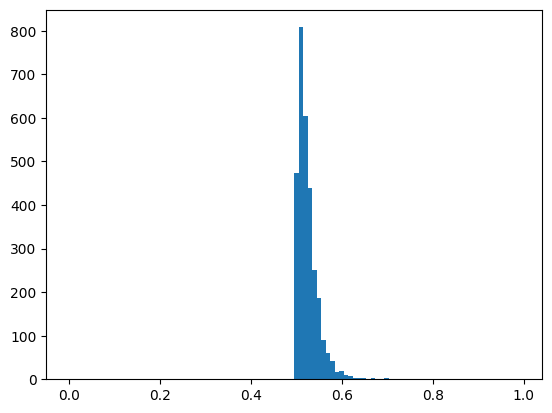

In [40]:
new_audio_lens = []
refined_buckeye = []

for sample in buckeye:
    subsamples = split_utterance_into_multiple(sample[2], sample[1], 0.01, 30)
    for subsample in subsamples:
        new_audio_lens.append(len(subsample[1]) / 16000 / 60)
        refined_buckeye.append((subsample[0], subsample[1]))

#  plot audio lens
plt.hist(np.array(new_audio_lens), bins=100)
new_total_audio = sum(np.array(new_audio_lens))
print("total audio length in minutes:", new_total_audio)

#### Doreco dataset
**About**: 600 samples, 0.002-0.5 minutes, 44 minutes, no audio cropping 

Contains shorter really ambiguous short clips less than 1 second. future work may remove these

Vocab: {'ŋ', 'b', 'd', 'ɪ', 'f', 'r', 'ð', 'ə', 'l', 'ɑ', 'k', 'v', 'a', 'æ', 'h', 'θ', 'ɔ', 'ɡ', 'w', 'ɒ', 'ʌ', 'z', 'u', 'n', 'e', 'dz', 'ɹ', 'm', 'dʒ', 'ts', 'ʒ', 't', 'p', 'ɡb', 'ɜ', 's', 'i', 'j', 'ʊ', 'tʃ', 'ʃ'}

not found: ['dz', 'ɡb']

In [41]:
doreco = DoReCoDataset(split="all")

check audio length

total audio 44.85913229166667


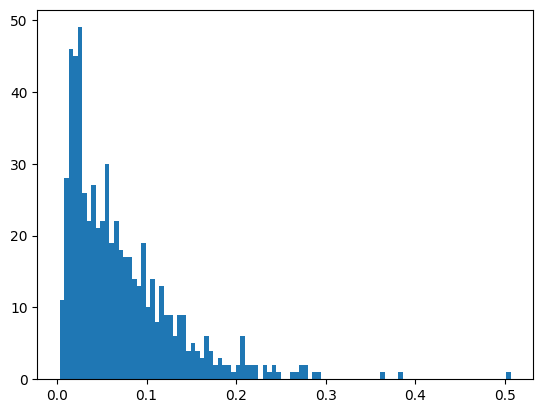

In [42]:
audio_lens = []
for sample in doreco:
    audio_lens.append(len(sample[1]) / 16_000 / 60)
plt.hist(audio_lens, bins=100)
print("total audio", sum(audio_lens))

#### Speech Ocean dataset
**About**: 2481 samples 0.02-0.34 minutes, 170 minutes, no audio cropping

Some samples are highly biased in their annotation. We will remove any samples have been mis-annotated with the unvoiced and voiced "th" but should have been annotated with "z" instead. 

vocab: {'ɛ', 'ŋ', 'b', 'd', 'ʍ', 'ɪ', 'f', 'ɾ̃', 'ə', 'l', 'ɑ', 'k', 'v', 'aɪ', 'oʊ', 'æ', 'n̩', 'h', 'θ', 'ɾ', 'ɔ', 'ɡ', 'w', 'ʌ', 'ʉ', 'z', 'ɝ', 'eɪ', 'u', 'ʔ', 'ɨ', 'ɔɪ', 'n', 'aʊ', 'ɹ', 'm', 'dʒ', 'ʒ', 'm̩', 't', 'p', 'ɚ', 'ʊ', 's', 'i', 'j', 'l̩', 'ð', 'tʃ', 'ʃ'}

not found: ['ɝ', 'ɾ̃', 'ʍ', 'm̩']

In [43]:
speech_ocean = SpeechOceanDataset(split="train")

removing biased annotations

In [44]:
refined_speech_ocean = [
    sample for sample in speech_ocean if "ð" not in sample[0] and "θ" not in sample[0]
]

print(f"Original number of samples: {len(speech_ocean)}")
print(f"Filtered number of samples: {len(refined_speech_ocean)}")

Original number of samples: 2481
Filtered number of samples: 1120


check audio length

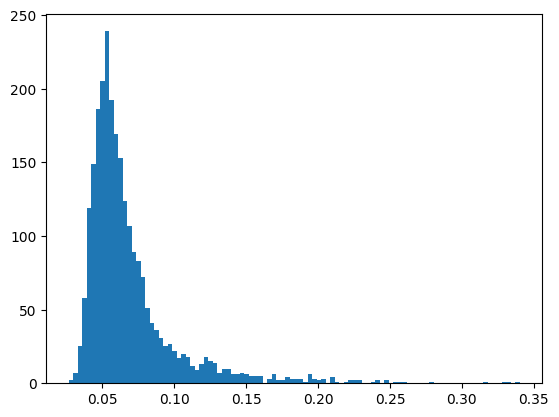

In [45]:
audio_lens = []
for sample in speech_ocean:
    audio_lens.append(len(sample[1]) / 16000 / 60)
plt.hist(audio_lens, bins=100);

#### L2 Arctic Scripted 
**About**: 3599 samples, 0.015-0.155 min, 219 minutes, no audio cropping
and remove stress markers

vocab: {'ɛ', 'ŋ', 'b', 'd', 'ʍ', 'ɪ', 'f', 'ɾ̃', 'ə', 'l', 'ɑ', 'k', 'v', 'aɪ', 'oʊ', 'æ', 'n̩', 'h', 'θ', 'ɾ', 'ɔ', 'ɡ', 'w', 'ʌ', 'ʉ', 'z', 'ɝ', 'eɪ', 'u', 'ʔ', 'ɨ', 'ɔɪ', 'n', 'aʊ', 'ɹ', 'm', 'dʒ', 'ʒ', 'm̩', 't', 'p', 'ɚ', 'ʊ', 's', 'i', 'j', 'l̩', 'ð', 'tʃ', 'ʃ'}

not found: ['ɝ', 'ɾ̃', 'ʍ', 'm̩']

In [46]:
# load all_arctic_speaker_splits
arctic = all_arctic_speaker_splits(include_timestamps=True)  # scripted speech
for sample in arctic:
    sample = (remove_stress_marker(sample[0]), sample[1])

arctic audio lens median: 0.05993125


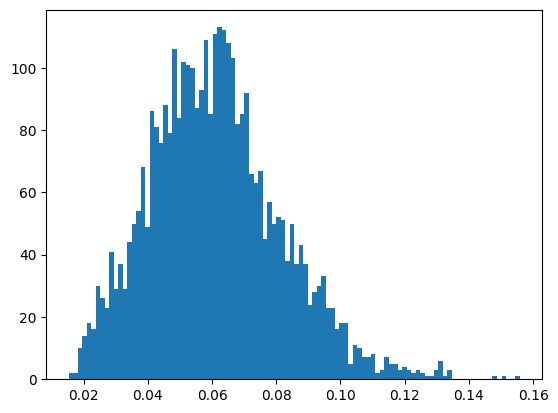

In [47]:
audio_lens = []
for sample in arctic:
    audio_lens.append(len(sample[1]) / 16000 / 60)
plt.hist(audio_lens, bins=100)
print(f"arctic audio lens median: {np.median(audio_lens)}")

### make train_df

In [ ]:
# your dict of lists/tuples
datasets = {
    "psst": psst,
    "refined_speech_ocean": refined_speech_ocean,
    "arctic": arctic,
    "doreco": doreco,
    "epadb": epadb,
    "refined_buckeye": refined_buckeye,
    "timit": timit,  # high quality
    "refined_suitcase": refined_suitcase,  # high quality
}

all_items = [(item[0], item[1]) for _, lst in datasets.items() for item in lst]

In [ ]:
train_df = pd.DataFrame(all_items, columns=["audio", "ipa"])

### Mapping unmatched vocab tokens to approximations in Facebook

In [80]:
UNMATCHED_VOCAB = {
    "ŋ̍",
    "oʊ̃",
    "ɡb",
    "ʟ",
    "ĩ",
    "ɡɣ",
    "ə̃",
    "sʰ",
    "aɪ̃",
    "oʊ",
    "θʰ",
    "ə̥",
    "ɾ̃",
    "ʍ",
}

In [82]:
partial_unmatched = {
    "ŋ̍": [263, 39],
    "oʊ̃": [225, 17, 31],
    "ɡb": [21, 43],
    "ɡɣ": [43, 99],
    "ə̃": [10, 129],
    "sʰ": [6, 220],
    "aɪ̃": [7, 8, 48],
    "oʊ": [31, 17],
    "θʰ": [37, 220],
    "ə̥": [10, 36],
}

In [83]:
full_unmatched = {
    "ʍ": 28,  # maps to token w
    "ʟ": 80,  # maps to token ɫ
    "ĩ": 15,
    "ɾ̃": 34,  # maps to token ɾ
}

# "tʰ": 95

* Perfect Matches (MATCHED_VOCAB): Ensure perfect matches get Facebook weights directly, ignoring partial matches.
* Partial Matches: Transfer Facebook weights to partial matches, averaging weights for tokens with multiple partial matches (e.g., "dz").
* Unmatched Tokens: Use specified Facebook token IDs, transfer weights, and add a small epsilon for differentiation

* Final Vocab: Combine partial_unmatched, full_unmatched, and MATCHED_VOCAB to create a condensed vocab.



In [84]:
# for weight transfer
from transformers import (
    AutoModelForCTC,
    AutoTokenizer,
    Wav2Vec2CTCTokenizer,
)

SPECIALS = ["<pad>", "<s>", "</s>", "<unk>"]

SAVE_DIR = pathlib.Path("facebook53_condensed")
SAVE_DIR.mkdir(exist_ok=True)

token_sequence = (
    SPECIALS
    + sorted(MATCHED_VOCAB)
    + sorted(partial_unmatched.keys())
    + sorted(full_unmatched.keys())
)


vocab_dict = {tok: idx for idx, tok in enumerate(token_sequence)}

tok_dir = SAVE_DIR / "tokenizer"
tok_dir.mkdir(exist_ok=True)
(tok_dir / "vocab.json").write_text(
    json.dumps(vocab_dict, ensure_ascii=False, indent=2)
)

tokenizer = Wav2Vec2CTCTokenizer(
    str(tok_dir / "vocab.json"), pad_token="<pad>", unk_token="<unk>"
)
tokenizer.save_pretrained(tok_dir)

# load pretrained model & stash old head
base = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
old_W = base.lm_head.weight.data.clone()
old_b = base.lm_head.bias.data.clone()

# shrink lm_head & update vocab_size
in_feats = base.lm_head.in_features
base.lm_head = torch.nn.Linear(in_feats, len(vocab_dict), bias=True)
base.config.vocab_size = len(vocab_dict)
torch.nn.init.normal_(base.lm_head.weight, std=0.02)

new_W, new_B = base.lm_head.weight.data, base.lm_head.bias.data
old_tok = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
old2id = old_tok.get_vocab()

rng = torch.Generator().manual_seed(0)
jitter = lambda v, s=0.01: v + torch.empty_like(v).uniform_(-s, s, generator=rng)

# copy / average / jitter weights
for tok in SPECIALS + list(MATCHED_VOCAB):
    new_W[vocab_dict[tok]] = old_W[old2id[tok]]
    new_B[vocab_dict[tok]] = old_b[old2id[tok]]

for tok, ids in partial_unmatched.items():
    new_W[vocab_dict[tok]] = torch.stack([old_W[i] for i in ids]).mean(0)
    new_B[vocab_dict[tok]] = torch.stack([old_b[i] for i in ids]).mean(0)

for tok, parent in full_unmatched.items():
    new_W[vocab_dict[tok]] = jitter(old_W[parent])
    new_B[vocab_dict[tok]] = old_b[parent]

# bundle feature-extractor so processor loads cleanly
fe = Wav2Vec2FeatureExtractor.from_pretrained(PRE_TRAINED_ID)
Wav2Vec2Processor(feature_extractor=fe, tokenizer=tokenizer).save_pretrained(
    SAVE_DIR
)  # writes preprocessor_config.json

# sanity-check & save model
print(" transfer complete")
print(f"   old head rows : {old_W.size(0)}")
print(f"   new head rows : {new_W.size(0)}")
print(f"   max old2id    : {max(old2id.values())}")
print(f"   max vocab id  : {max(vocab_dict.values())}\n")

base.save_pretrained(SAVE_DIR)
print("🚀  Condensed checkpoint saved to", SAVE_DIR.resolve())

✅  transfer complete
   old head rows : 272
   new head rows : 82
   max old2id    : 271
   max vocab id  : 81

🚀  Condensed checkpoint saved to /Users/arunasrivastava/Koel/ML-eval/ML/notebooks/facebook53_condensed_unduped


In [87]:
CONDENSED_DIR = "/Users/arunasrivastava/Koel/ML-eval/ML/notebooks/facebook53_condensed"

sanity check on the revised vocab model:

In [89]:
ckpt = pathlib.Path(CONDENSED_DIR)
processor = Wav2Vec2Processor.from_pretrained(CONDENSED_DIR)
model = AutoModelForCTC.from_pretrained(CONDENSED_DIR).eval()

wav, sr = torchaudio.load(
    "/Users/arunasrivastava/Koel/ML-eval/ML/data/ExamplesWithComments/TIMIT_sample_0.wav"
)
if sr != 16_000:
    wav = torchaudio.functional.resample(wav, sr, 16_000)

with torch.no_grad():
    logits = model(
        processor(wav.squeeze(), sampling_rate=16_000, return_tensors="pt").input_values
    ).logits
print(processor.tokenizer.batch_decode(logits.argmax(-1))[0])

# should look something like:
# prev = "aɪɻaɪtæktəstʌmptəweɪɪdɪɒtɪklɪ" (facebook)
# curr = "aɪraɪtæktəstʌmptəʍeɪɪdɪɒtɪklɪ" (new)

aɪraɪtæktəstʌmptəʍeɪɪdɪɒtɪklɪ


# hyperparam search


In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Dynamically pad *both* the acoustic inputs and the target
    label sequences for CTC training.

    Notes
    -----
    • Speech features are padded with 0.0 (default supplied by
      `Wav2Vec2Processor.pad`).
    • Label padding indices are replaced with **–100**, so that
      `nn.CTCLoss` ignores them.
    """

    processor: Wav2Vec2Processor
    padding: bool | str = True  # "longest" | "max_length" | True
    pad_to_multiple_of: int | None = None  # e.g. 8 for tensor cores

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # ─── 1) separate source and target sequences ──────────────────────────────
        input_values = [f["input_values"] for f in features]
        labels = [f["labels"] for f in features]

        # ─── 2) pad acoustic inputs ──────────────────────────────────────────────
        acoustic_batch = self.processor.pad(
            {"input_values": input_values},
            padding=self.padding,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # ─── 3) pad label sequences (using target processor branch) ──────────────
        with self.processor.as_target_processor():
            label_batch = self.processor.pad(
                {"input_ids": labels},
                padding=self.padding,
                pad_to_multiple_of=self.pad_to_multiple_of,
                return_tensors="pt",
            )

        # ─── 4) replace label padding with -100 so CTCLoss ignores it ────────────
        labels_padded = label_batch["input_ids"]
        padding_mask = label_batch["attention_mask"].ne(1)  # 1 ↔ real token
        labels_padded[padding_mask] = -100

        # ─── 5) assemble final batch ─────────────────────────────────────────────
        acoustic_batch["labels"] = labels_padded
        return acoustic_batch


logger = logging.getLogger(__name__)


def prepare_datasets(train_df, processor):
    """Split dataframe, resample audio, and tokenize IPA labels."""
    logger.info("Splitting dataset into train / eval …")
    train_data, eval_data = train_test_split(
        train_df, test_size=0.20, random_state=42, shuffle=True
    )

    def process_row(row):
        # ① audio → float32 @16 kHz
        audio = preprocess_audio(row["audio"])

        # ② acoustic features (no padding yet)
        inputs = processor(
            audio, sampling_rate=TARGET_SAMPLE_RATE, return_tensors=None
        )  # numpy 1-D
        input_values = np.asarray(inputs["input_values"][0], dtype=np.float32)

        # ③ tokenize IPA label sequence
        with processor.as_target_processor():
            labels = processor(row["ipa"]).input_ids

        return {
            "input_values": input_values,
            "labels": labels,
            # keep audio only if you need it for debugging / viz
        }

    # The incoming dataframe columns are ["audio", "ipa", …]
    train_ds = Dataset.from_pandas(train_data)
    eval_ds = Dataset.from_pandas(eval_data)

    keep_cols = ["input_values", "labels"]

    train_ds = train_ds.map(
        process_row,
        batched=False,
        num_proc=NUM_PROC_MAP,
        remove_columns=train_ds.column_names,  # drop originals
    ).select_columns(keep_cols)

    eval_ds = eval_ds.map(
        process_row,
        batched=False,
        num_proc=NUM_PROC_MAP,
        remove_columns=eval_ds.column_names,
    ).select_columns(keep_cols)

    return train_ds, eval_ds


def preprocess_audio(audio_np: np.ndarray) -> np.ndarray:
    """
    Ensures dtype == float32 (CTC models expect float32 tensors).
    """
    return audio_np.astype(np.float32, copy=False)


def prepare_model_and_processor(
    freeze_feature_extractor: bool | None = None,
    seed: int = RNG_SEED,
):
    """
    1. Loads tokenizer + fine-tuned weights from `condensed_dir`.
    2. Loads the *feature extractor* from Facebook’s original model.
    3. Combines both into a single `Wav2Vec2Processor`.
    4. Optionally freezes the CNN frontend.
    """
    set_seed(seed)

    # ─── A) tokenizer & condensed model ───────────────────────────────────────
    model = AutoModelForCTC.from_pretrained(CONDENSED_DIR)
    tokenizer = model._get_name_or_path_tokenizer(CONDENSED_DIR)  # ↔ AutoCTCTokenizer

    # ─── B) feature extractor from original checkpoint ────────────────────────
    feat_extr = Wav2Vec2FeatureExtractor.from_pretrained(PRE_TRAINED_ID)

    # ─── C) bundle into a Processor ───────────────────────────────────────────
    processor = Wav2Vec2Processor(feature_extractor=feat_extr, tokenizer=tokenizer)

    # ─── D) optionally freeze the CNN encoder ─────────────────────────────────
    if freeze_feature_extractor:
        model.feature_extractor._freeze_feature_encoder()
        for p in model.feature_extractor.parameters():
            p.requires_grad = False

    return model, processor


def define_sweep_config():
    return {
        "name": "wav2vec2_ipa_condensed",
        "method": "random",
        "metric": {"name": "eval_wer", "goal": "minimize"},
        "parameters": {
            # optimiser
            "learning_rate": {
                "distribution": "log_uniform_values",
                "min": 1e-5,
                "max": 5e-4,
            },
            "weight_decay": {"values": [0.0, 0.01, 0.05]},
            # training regime
            "train_batch_size": {"values": [4, 8]},
            "gradient_accumulation_steps": {"values": [2, 4]},
            "num_train_epochs": {"values": [5, 10, 15]},
            "warmup_steps": {"values": [500, 1000, 2000]},
            # SpecAugment (time masking prob)
            "mask_time_prob": {
                "distribution": "uniform",
                "min": 0.05,
                "max": 0.15,
            },
            # model variant
            "freeze_feature_extractor": {"values": [True, False]},
        },
    }


def train_model(train_df, condensed_dir, config=None):
    """
    Launches one training run with hyper-params from wandb.config.
    """
    wandb.init(config=config)
    cfg = wandb.config

    # 1) model / processor ------------------------------------------------------
    model, processor = prepare_model_and_processor(
        condensed_dir=condensed_dir,
        freeze_feature_extractor=cfg.freeze_feature_extractor,
    )

    # 2) datasets ---------------------------------------------------------------
    train_ds, eval_ds = prepare_datasets(train_df, processor)

    collator = DataCollatorCTCWithPadding(
        processor,
        padding="longest",
        pad_to_multiple_of=8,  # helps Tensor Cores
    )

    # 3) evaluation metric (WER) -----------------------------------------------
    def compute_metrics(pred):
        pred_ids = np.argmax(pred.predictions, axis=-1)
        pred_text = processor.batch_decode(pred_ids)

        # replace -100 with pad_token_id before decoding
        label_ids = np.where(
            pred.label_ids != -100, pred.label_ids, processor.tokenizer.pad_token_id
        )
        label_text = processor.batch_decode(label_ids, group_tokens=False)

        return {"per": per(label_text, pred_text)}

    # 4) HF Trainer -------------------------------------------------------------
    args = TrainingArguments(
        output_dir=f"./runs/{wandb.run.id}",
        learning_rate=cfg.learning_rate,
        per_device_train_batch_size=cfg.train_batch_size,
        per_device_eval_batch_size=cfg.train_batch_size,
        gradient_accumulation_steps=cfg.gradient_accumulation_steps,
        num_train_epochs=cfg.num_train_epochs,
        warmup_steps=cfg.warmup_steps,
        weight_decay=cfg.weight_decay,
        fp16=torch.cuda.is_available(),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_steps=50,
        dataloader_num_workers=4,
        save_total_limit=2,
        report_to=["wandb"],
    )

    # propagate SpecAugment param
    model.config.mask_time_prob = cfg.mask_time_prob

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        data_collator=collator,
        tokenizer=processor.feature_extractor,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_metrics = trainer.evaluate()
    wandb.log({"eval_wer": eval_metrics["eval_wer"]})
    wandb.finish()


# --- Sweep launcher --------------------------------------------------------------
def run_sweep(train_df, condensed_dir, sweep_trials: int = 30):
    """
    Creates the sweep → spawns an agent that runs `sweep_trials` jobs.
    """
    sweep_id = wandb.sweep(
        define_sweep_config(),
        project="wav2vec2_ipa_condensed",
    )

    agent_fn = functools.partial(
        train_model,
        train_df=train_df,
        condensed_dir=condensed_dir,
    )

    wandb.agent(sweep_id, function=agent_fn, count=sweep_trials)
    return sweep_id


# --- Script entry-point ------------------------------------------------------------
if __name__ == "__main__":
    # assume `train_df` already exists in your notebook namespace
    SWEEP_ID = run_sweep(
        train_df=train_df,
        condensed_dir="notebooks/facebook60_condensed",
        sweep_trials=30,  # adjust
    )
    print("🚀 sweep launched lets goooo:", SWEEP_ID)

## V2 resize finetuning 

In [ ]:
import json
import torch
import logging
import tempfile
import wandb
import numpy as np
from transformers import (
    AutoProcessor,
    AutoModelForCTC,
    Trainer,
    TrainingArguments,
    Wav2Vec2CTCTokenizer,
    EarlyStoppingCallback,
)
from datasets import Dataset
from dataclasses import dataclass
from typing import Dict, List, Union, Any
import torchaudio
from sklearn.model_selection import train_test_split
import os
import time
from datetime import datetime
import GPUtil
import psutil

# Constants and logging setup as before
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000
MAX_LABEL_LENGTH = 100

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class TrialTimeTracker:
    def __init__(self, output_file):
        self.output_file = output_file
        self.current_trial = None
        self.start_time = None

    def start_trial(self, config):
        self.current_trial = {
            "config": config,
            "start_time": datetime.now().isoformat(),
            "gpu_type": self._get_gpu_type(),
            "timestamps": [],
        }
        self.start_time = time.time()

    def log_timestamp(self, step_name):
        if self.current_trial:
            gpu_metrics = self._get_gpu_metrics()
            timestamp = {
                "step": step_name,
                "elapsed_seconds": time.time() - self.start_time,
                **gpu_metrics,
            }
            self.current_trial["timestamps"].append(timestamp)
            logger.info(
                f"Step {step_name} completed after {timestamp['elapsed_seconds']:.2f}s"
            )

    def _get_gpu_type(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return gpu.name
        except:
            return "Unknown"

    def _get_gpu_metrics(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return {
                "gpu_utilization": gpu.load * 100,
                "gpu_memory_used": gpu.memoryUsed,
                "gpu_memory_total": gpu.memoryTotal,
            }
        except:
            return {
                "gpu_utilization": None,
                "gpu_memory_used": None,
                "gpu_memory_total": None,
            }


@dataclass
class DataCollatorCTCWithPadding:
    # Same as before
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        max_length = min(
            max(len(feature["input_values"]) for feature in features), MAX_AUDIO_LENGTH
        )
        padded_inputs = []
        attention_mask = []

        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length

            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]

            input_values = input_values.squeeze()

            if padding_length > 0:
                padded_input = torch.nn.functional.pad(
                    input_values, (0, padding_length)
                )
                attention_mask.append(
                    torch.cat([torch.ones(input_length), torch.zeros(padding_length)])
                )
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))

            padded_inputs.append(padded_input)

        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask),
        }

        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )
        batch["labels"] = labels

        return batch


def prepare_model_and_processor(pre_trained_id, timit_vocab, base_dir):
    """Prepare model and processor with vocabulary resizing"""
    logger.info("Loading pretrained model and processor...")

    os.makedirs(base_dir, exist_ok=True)
    processor = AutoProcessor.from_pretrained(pre_trained_id)
    model = AutoModelForCTC.from_pretrained(pre_trained_id)

    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")

    special_tokens = {"[PAD]": 0, "<s>": 1, "</s>": 2, "[UNK]": 3}

    regular_tokens = sorted(list(timit_vocab - set(["<pad>", "<unk>"])))
    vocab = {**special_tokens}

    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)

    logger.info(f"New vocabulary size: {len(vocab)}")

    vocab_file = os.path.join(base_dir, "vocab.json")
    with open(vocab_file, "w") as f:
        json.dump(vocab, f, indent=2)

    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "[PAD]",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "[UNK]",
    }

    with tempfile.NamedTemporaryFile(mode="w", delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name

    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path, **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )

    processor.tokenizer = new_tokenizer

    # Save processor configuration
    processor_path = os.path.join(base_dir, "processor")
    processor.save_pretrained(processor_path)

    # Resize the linear head
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data

    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    torch.nn.init.xavier_uniform_(new_layer.weight.data, gain=0.1)
    new_layer.bias.data.uniform_(-0.1, 0.1)

    transfer_count = 0
    for token, new_idx in vocab.items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]
            transfer_count += 1

    logger.info(f"Transferred weights for {transfer_count} tokens")

    model.lm_head = new_layer
    model.config.vocab_size = len(vocab)
    model.config.pad_token_id = special_tokens["[PAD]"]
    model.config.bos_token_id = special_tokens["<s>"]
    model.config.eos_token_id = special_tokens["</s>"]
    model.config.unk_token_id = special_tokens["[UNK]"]

    return model, processor


def prepare_datasets(train_df, processor):
    """Dataset preparation with optimized batch processing"""
    # Same as before
    logger.info("Splitting dataset into train and evaluation...")

    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)

    def process_data(batch):
        audio = preprocess_audio(batch["audio"])
        audio = audio.squeeze()

        inputs = processor(audio, sampling_rate=SAMPLING_RATE, return_tensors=None)

        input_values = np.squeeze(inputs["input_values"])

        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids

        return {"input_values": input_values, "labels": labels, "audio": audio}

    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)

    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"],
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"],
    )

    return train_dataset, eval_dataset


def preprocess_audio(audio_input):
    """Audio preprocessing function"""
    # Same as before
    if isinstance(audio_input, str):
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
    elif isinstance(audio_input, (list, np.ndarray, torch.Tensor)):
        audio_numpy = np.array(audio_input, dtype=np.float32)
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")

    audio_numpy = audio_numpy.astype(np.float32)
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)

    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()

    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])

    return audio_numpy


def run_finetuning(train_df, pre_trained_id, timit_vocab, output_dir):
    """Run finetuning with optimal hyperparameters"""
    tracker = TrialTimeTracker(os.path.join(output_dir, "finetuning_log.jsonl"))

    config = {
        "learning_rate": 9.999999999999999e-05,
        "per_device_train_batch_size": 4,
        "per_device_eval_batch_size": 4,
        "gradient_accumulation_steps": 2,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "max_grad_norm": 1.0,
        "adam_beta1": 0.9,
        "adam_beta2": 0.975,
        "adam_epsilon": 1e-08,
    }

    wandb.init(
        project="xlsr-phoneme-finetuning-final",
        name="finetuning_optimal_params",
        config=config,
    )

    tracker.start_trial(config)

    tracker.log_timestamp("model_init_start")
    model, processor = prepare_model_and_processor(
        pre_trained_id, timit_vocab, output_dir
    )
    model.gradient_checkpointing_enable()
    tracker.log_timestamp("model_init_complete")

    tracker.log_timestamp("dataset_prep_start")
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)
    tracker.log_timestamp("dataset_prep_complete")

    training_args = TrainingArguments(
        output_dir=output_dir,
        **config,
        num_train_epochs=20,
        logging_steps=50,
        save_steps=100,
        eval_steps=100,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_strategy="steps",
        save_total_limit=2,
        fp16=True,
        dataloader_num_workers=16,
        gradient_checkpointing=True,
        dataloader_prefetch_factor=4,
        ddp_find_unused_parameters=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=DataCollatorCTCWithPadding(
            processor=processor, padding="longest"
        ),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    tracker.log_timestamp("training_start")
    train_result = trainer.train()
    tracker.log_timestamp("training_complete")

    eval_result = trainer.evaluate()
    tracker.log_timestamp("evaluation_complete")

    logger.info("Saving final model and processor...")
    trainer.save_model(os.path.join(output_dir, "final_model"))
    processor.save_pretrained(os.path.join(output_dir, "final_processor"))

    wandb.finish()


if __name__ == "__main__":
    run_finetuning(
        train_df=train_df,  # Your training DataFrame
        pre_trained_id=PRE_TRAINED_ID,  # Your pretrained model ID
        timit_vocab=timit_vocab,  # Your TIMIT vocabulary set
        output_dir="./results/finetune_resize_final",
    )

## Save Model on Hugging Face

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
from huggingface_hub import login

# Log in to Hugging Face (if not already logged in)
# login("your-huggingface-api-token")

# Load the model and processor from your local directory
model = AutoModelForCTC.from_pretrained("/home/arunasrivastava/ML/notebooks/results-b0")
processor = Wav2Vec2Processor.from_pretrained(
    "/home/arunasrivastava/ML/notebooks/results-b0"
)

# Specify the directory where you want to save the model
save_directory = "./xlsr-timit-b0"

# Save and upload to Hugging Face Model Hub under an organization
model.save_pretrained(
    save_directory, push_to_hub=True, repo_id="KoelLabs/xlsr-timit-b0"
)
processor.save_pretrained(save_directory)

# Instructions to Upload Model to Hugging Face

1. **Login to Hugging Face**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli login


2. **Create a Repository**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli repo create your-model-name --organization your-org-name

3. **Git clone**  
   Run the following command to clone your repo:
   ```bash 
   git clone https://huggingface.co/your-org-name/your-model-name

4. **Upload Model**  (if you did not make it on Hugging Face already)
   Run the following command to clone your repo:
   ```bash 
   huggingface-cli repo upload --path ./<path here>


5. **Move Other Files**  
   Run the following command to copy each file into the repo:
   ```bash
   cp -r ./<path here> <your-cloned-repo-folder> 

6. **Stage & Commit!**
    Run the following git commands
    ```bash
    git add README.md
    git commit -m "Add model card"
    git push


### YAAAAY CONGRATULATIONS 

# (Optional) Hyperparam search
